In [1]:
#%matplotlib inline
import pandas as pd
import json
import numpy as np
import os
import re
import time
import math
from matplotlib import pyplot as plt
from collections import defaultdict
from itertools import combinations
import networkx as nx
from scipy.stats import pearsonr
from concurrent.futures import ProcessPoolExecutor
import ast

## Create Layer 1

In [2]:
import networkx as nx
import ast

def create_layer1_threshold(edges_dict, k_value, undirected=False):
    """
    Create a network layer by filtering edges based on a threshold and normalizing weights using min-max normalization.

    Args:
        edges_dict (dict): Dictionary containing edge data, where keys are edge tuples (as strings)
                           and values are dictionaries with weight data.
        threshold (float): Threshold for including edges in the graph.
        undirected (bool): Whether the graph is undirected or directed.

    Returns:
        nx.Graph or nx.DiGraph: A graph object containing edges that pass the threshold.
    """
    # Step 1: Extract all weights to find min and max values
    if undirected:
        weights = [edge_data['simmetric_weight'] for edge_data in edges_dict.values()]
    else:
        weights = [
            weight 
            for edge_data in edges_dict.values() 
            for weight in (edge_data['weight_user1'], edge_data['weight_user2'])
        ]
    threshold = np.percentile(np.array(weights), k_value)
    # Compute min and max weights for normalization
    w_min = min(weights)
    w_max = max(weights)

    # Avoid division by zero in case all weights are the same
    if w_max == w_min:
        normalize = lambda w: 1.0  # Set all normalized weights to 1.0
    else:
        normalize = lambda w: (w - w_min) / (w_max - w_min)  # Min-max normalization

    threshold = (threshold -w_min) / (w_max - w_min)
    # Step 2: Create the graph
    if undirected:
        G = nx.Graph()
        for edge, edge_data in edges_dict.items():
            e = ast.literal_eval(edge)
            normalized_weight = normalize(edge_data['simmetric_weight'])
            if normalized_weight > threshold:
                G.add_edge(e[0], e[1], weight=normalized_weight)
    else:
        G = nx.DiGraph()
        for edge, edge_data in edges_dict.items():
            e = ast.literal_eval(edge)
            normalized_weight_user1 = normalize(edge_data['weight_user1'])
            normalized_weight_user2 = normalize(edge_data['weight_user2'])
            if normalized_weight_user1 > threshold:
                G.add_edge(e[0], e[1], weight=normalized_weight_user1)
            if normalized_weight_user2 > threshold:
                G.add_edge(e[1], e[0], weight=normalized_weight_user2)

    return G


def get_percentile(edges, k_value):
    weights = []
    for edge, edge_dict in edges.items():
        weights.append(edge_dict['simmetric_weight'])
    return np.percentile(np.array(weights), k_value)

In [3]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edges_dict_weight.json'
with open(file_path, "r") as json_file:
    edges_dict = json.load(json_file)

In [4]:
layer1 = create_layer1_threshold(edges_dict, 90, undirected=True)

In [5]:
weights = [data['weight'] for u, v, data in layer1.edges(data=True)]

## Create Layer 2

In [6]:
def calculate_similarity_index2(users_items, item_rarity, item_collections, alpha=0.5, collection_rarity=None):
    """
    Calculates edge weights (similarity indices) between user pairs with normalization
    and dynamic threshold adjustment.
    
    Args:
        users_items (dict): Maps users to their collectible items.
        item_rarity (dict): Maps items to their rarity (lower = rarer).
        item_collections (dict): Maps items to their collections.
        alpha (float): Weight for collection-based similarity (default: 0.5).
        collection_rarity (dict): Maps collections to their rarity (optional).
    
    Returns:
        list: List of tuples (user1, user2, normalized weight).
    """
    edges = []

    # Find all user pairs
    user_pairs = combinations(users_items.keys(), 2)

    for user1, user2 in user_pairs:
        # Get the items of each user
        items1 = set(users_items[user1])
        items2 = set(users_items[user2])

        if not items1 or not items2:
            continue

        # Compute shared items and collections
        common_items = items1.intersection(items2)
        collections1 = {item_collections[item] for item in items1}
        collections2 = {item_collections[item] for item in items2}
        common_collections = collections1.intersection(collections2)

        if not common_items and not common_collections:
            continue

        # Compute item rarity-based weight
        weight_rarity = sum(1 / item_rarity[item] for item in common_items)

        # Compute collection similarity weight
        if collection_rarity:
            weight_collections = sum(1 / collection_rarity[collection] for collection in common_collections)
        else:
            weight_collections = len(common_collections)

        # Calculate raw similarity index
        raw_weight = weight_rarity + alpha * weight_collections

        # Normalize weight
        max_possible_rarity = sum(1 / item_rarity[item] for item in items1.union(items2))
        max_possible_collections = len(collections1.union(collections2)) if not collection_rarity else \
                                   sum(1 / collection_rarity[collection] for collection in collections1.union(collections2))
        max_possible_weight = max_possible_rarity + alpha * max_possible_collections
        normalized_weight = raw_weight / max_possible_weight

        # Dynamic threshold adjustment
        threshold = 0.0  # Example threshold scaling
        if normalized_weight >= threshold:
            edges.append((user1, user2, normalized_weight))

    return edges


def compute_edges2(all_wearables, alpha=0.5, wearable_to_collection=None):
    """
    Computes edges with normalized weights and dynamic threshold adjustment between users.
    
    Args:
        all_wearables (dict): Maps users to their wearables.
        alpha (float): Weight for collection-based similarity (default: 0.5).
    
    Returns:
        list: List of edges (user1, user2, normalized weight).
    """
    users_items = {}
    item_rarity = {}
    item_collections = {}
    collection_rarity = {}

    # Populate users_items, item_rarity, and item_collections
    for user, wearables in all_wearables.items():
        users_items[user] = []
        for wearable in wearables:
            nft_name = wearable['nft_name']
            if wearable_to_collection:
                nft_collection = wearable_to_collection[nft_name]
            else:
                nft_collection = wearable['nft_collection']

            item_rarity[nft_name] = item_rarity.get(nft_name, 0) + 1
            collection_rarity[nft_collection] = collection_rarity.get(nft_collection, 0) + 1
            users_items[user].append(nft_name)
            item_collections[nft_name] = nft_collection

    # Compute edges with the new similarity function
    edges = calculate_similarity_index2(users_items, item_rarity, item_collections, alpha, collection_rarity)

    return edges


In [7]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/address_to_wearables.json'
with open(file_path, "r") as json_file:
    address_to_wearables = json.load(json_file)

In [8]:
k = 15
new_address_to_wearables = {}
num_wearables = []

for address, wearables in address_to_wearables.items():
    num_wearables.append(len(wearables))
    if len(wearables) < k:
        continue
    new_address_to_wearables[address] = wearables

In [9]:
alpha = 0.5

edges = compute_edges2(new_address_to_wearables, alpha)

In [10]:
# Get an array of weights
weights = []

for edge in edges:
    weights.append(edge[2])

weights = np.array(weights)

In [11]:
def create_layer2(edges, threshold):
    G = nx.Graph()
    for edge in edges:
        if edge[2] > threshold:
            G.add_edge(edge[0], edge[1], weight = edge[2]) 
    return G

threshold = np.percentile(weights, 90)
layer2 = create_layer2(edges, threshold)

## Null model

## Metrics

In [12]:
from scipy.stats import pearsonr, spearmanr 

def calculate_layer_correlation(layer1, layer2):
    edges1 = {(u, v): d['weight'] for u, v, d in layer1.edges(data=True)}
    edges2 = {(u, v): d['weight'] for u, v, d in layer2.edges(data=True)}

    common_edges = set(edges1.keys()).intersection(set(edges2.keys()))
    weights1 = [edges1[edge] for edge in common_edges]
    weights2 = [edges2[edge] for edge in common_edges]
    #print(np.cov(weights1, weights2))

    return spearmanr(weights1, weights2)


In [13]:
import numpy as np
from scipy.stats import spearmanr

def analyze_layer_correlation(layer1, layer2, weights1, weights2):
    """
    Analyze correlation and overlap between two layers.

    Args:
        layer1 (set): Edge set of the first layer (e.g., {(u, v), ...}).
        layer2 (set): Edge set of the second layer.
        weights1 (dict): Weights of edges in the first layer, e.g., {(u, v): weight}.
        weights2 (dict): Weights of edges in the second layer, e.g., {(u, v): weight}.
    
    Returns:
        dict: Metrics including Spearman correlation, edge overlap, and composite score.
    """
    # Find common edges
    common_edges = layer1 & layer2
    num_common_edges = len(common_edges)
    
    # Edge overlap ratio
    edge_overlap_ratio = num_common_edges / min(len(layer1), len(layer2))
    
    # Extract weights for common edges
    common_weights1 = [weights1[edge] for edge in common_edges]
    common_weights2 = [weights2[edge] for edge in common_edges]
    
    # Compute Spearman correlation
    if len(common_edges) > 1:
        correlation, _ = spearmanr(common_weights1, common_weights2)
    else:
        correlation = 0  # Not enough data for correlation
    
    # Composite score (adjust alpha as needed)
    alpha = 0.5
    composite_score = alpha * correlation + (1 - alpha) * edge_overlap_ratio
    
    return {
        "correlation": correlation,
        "edge_overlap_ratio": edge_overlap_ratio,
        "composite_score": composite_score,
        "num_common_edges": num_common_edges,
    }



## Overlap

In [14]:
print(f'Number of edges (layer 2): {layer2.number_of_edges()}')
print(f'Number of nodes (layer2): {layer2.number_of_nodes()}')
print(f'Density (layer2): {nx.density(layer2)}')
print(f'Number of edges (layer 1): {layer1.number_of_edges()}')
print(f'Number of nodes (layer1): {layer1.number_of_nodes()}')
print(f'Density (layer1): {nx.density(layer1)}')

Number of edges (layer 2): 54210
Number of nodes (layer2): 1084
Density (layer2): 0.09235313959787797
Number of edges (layer 1): 55052
Number of nodes (layer1): 2599
Density (layer1): 0.01630638419881396


Sarebbe opportuno fare almeno 10N swaps (N è il numero di edges del network). Nel nostro caso N = 18592 quindi eseguiamo 200000 swaps.

## Overlap study

## z-test

In [15]:
import numpy as np

def compute_z_value(null_model_ratios, original_ratio):
    """
    Computes the z-value for the original edge overlap ratio compared to null models.
    
    Parameters:
    - null_model_ratios (array-like): Array of edge overlap ratios from null models.
    - original_ratio (float): Edge overlap ratio from the original dataset.
    
    Returns:
    - z_value (float): The z-value of the original ratio.
    """
    # Calculate the mean and standard deviation of the null models
    mean_null = np.mean(null_model_ratios)
    std_null = np.std(null_model_ratios, ddof=1)  # Use ddof=1 for sample standard deviation
    
    # Compute the z-value
    z_value = (original_ratio - mean_null) / (std_null)
    
    return z_value


## Cluster coefficient

In [16]:
clustering_coeff_layer2 = nx.clustering(layer2)
#clustering_coeff_null_model = nx.clustering(null_model)

In [17]:
clustering_coeff_layer2

{'0x00278990b4096bf24aa3f9591905f8070e938aeb': 0.6098291878933173,
 '0x009255de16f337807228955e9811dd20e3e69e55': 0.5045347360783602,
 '0x02340de91248a644efd784da68ddd78b96d23ddb': 0.5102564102564102,
 '0x05f9e911c9f1b1c22888c1d4f0995b9abab8917c': 0.5407407407407407,
 '0x06615c1e732b9e434391f458b1ce9a464481e77b': 0.3529177613247353,
 '0x0835827da42444736764af005387b6935305df49': 0.3680672268907563,
 '0x0c048ca8377a964ada1ebce173216f055201524f': 0.5579596118541831,
 '0x0fe4739ed4cc3f1da905da59598e29eac179b5f3': 0.49153858096568853,
 '0x12c633c8e014a27e9bf4ea86178a53454bd5640a': 0.3944389763779528,
 '0x131c1a450d4add7ef25d889fff6cedca9de61acb': 0.2595048629531388,
 '0x13a22264c3dce612dec8f6d8cd77385d631398dc': 0.5675112084245647,
 '0x1578a21a8cb187e387ed73edeb3a7e3734d4959d': 0.4704458054408204,
 '0x19902b9b2b8b54654dec2ded69d5af6fc8f24ac1': 0.6565110565110565,
 '0x1a33cdf7711e404cd160782feb027a5159f126b7': 0.4551299972043612,
 '0x1a57f5b513ae486ef201f8bc20e2987f208ad021': 0.707563025210

## Null model swaps

In [18]:
import networkx as nx
import random

def rewiring_with_clustering(G, n_steps=10000, tol=0.01):
    """
    Randomizza la rete preservando i gradi e mantenendo
    il clustering coefficient globale entro una tolleranza.
    
    Parametri:
        G       : grafo originale (networkx.Graph)
        n_steps : numero di tentativi di rewiring
        tol     : tolleranza relativa sul clustering globale
    """
    G_rand = G.copy()
    target_C = nx.transitivity(G)  # clustering globale originale
    
    for _ in range(n_steps):
        # scegli due archi diversi
        u, v = random.choice(list(G_rand.edges()))
        x, y = random.choice(list(G_rand.edges()))
        
        if len({u, v, x, y}) < 4:  # evita overlap
            continue
        
        # possibili nuove combinazioni
        if random.random() < 0.5:
            new_edges = [(u, x), (v, y)]
        else:
            new_edges = [(u, y), (v, x)]
        
        # controlla che non esistano già e che non siano self-loop
        if any(a == b or G_rand.has_edge(a, b) for a, b in new_edges):
            continue
        
        # fai la sostituzione temporanea
        G_rand.remove_edge(u, v)
        G_rand.remove_edge(x, y)
        G_rand.add_edges_from(new_edges)
        
        # ricontrolla clustering
        new_C = nx.transitivity(G_rand)
        if abs(new_C - target_C) / target_C > tol:
            # se fuori tolleranza, annulla
            G_rand.remove_edges_from(new_edges)
            G_rand.add_edge(u, v)
            G_rand.add_edge(x, y)
    
    return G_rand


In [19]:
import networkx as nx
import random

def rewiring_with_clustering_fast(G, n_steps=10000, tol_global=0.05, tol_local=None, seed=None):
    """
    Randomizza la rete preservando i gradi e mantenendo
    il clustering coefficient globale (e opzionalmente locale) entro tolleranza.

    Parametri:
        G           : grafo originale (networkx.Graph)
        n_steps     : numero di tentativi di rewiring
        tol_global  : tolleranza relativa sul clustering globale
        tol_local   : tolleranza relativa sul clustering per nodo (opzionale)
        seed        : per riproducibilità (opzionale)
    """
    counter = 0
    if seed is not None:
        random.seed(seed)
    
    # Copia del grafo originale
    G_rand = G.copy()
    
    # Clustering globale e numero totale di triangoli di riferimento
    target_global_C = nx.transitivity(G_rand)
    target_t = {n: _triangle_count(G_rand, n) for n in G_rand}
    total_triangles = sum(target_t.values()) / 3

    for step in range(n_steps):
        # scegli due archi distinti
        (u, v), (x, y) = random.sample(list(G_rand.edges()), 2)

        # evita nodi sovrapposti
        if len({u, v, x, y}) < 4:
            continue

        # scegli una permutazione (classico double-edge swap)
        if random.random() < 0.5:
            new_edges = [(u, x), (v, y)]
        else:
            new_edges = [(u, y), (v, x)]

        # evita self-loop o archi già presenti
        if any(a == b or G_rand.has_edge(a, b) for a, b in new_edges):
            continue

        # prepara i set dei vicini PRIMA del cambiamento
        Nu, Nv = set(G_rand[u]), set(G_rand[v])
        Nx, Ny = set(G_rand[x]), set(G_rand[y])

        # calcola i triangoli distrutti dai due archi rimossi
        destroyed = len(Nu & Nv) + len(Nx & Ny)

        # calcola i triangoli creati dai due nuovi archi
        (a1, b1), (a2, b2) = new_edges
        Na1, Nb1 = set(G_rand[a1]) - {b1}, set(G_rand[b1]) - {a1}
        Na2, Nb2 = set(G_rand[a2]) - {b2}, set(G_rand[b2]) - {a2}
        created = len(Na1 & Nb1) + len(Na2 & Nb2)

        # delta totale di triangoli
        delta_triangles = created - destroyed
        new_total_triangles = total_triangles + delta_triangles

        # calcola nuovo clustering globale
        possible_triads = sum(k * (k - 1) / 2 for _, k in G_rand.degree())
        if possible_triads == 0:
            new_global_C = 0
        else:
            new_global_C = (3 * new_total_triangles) / possible_triads

        # controllo di accettazione sul clustering globale
        if target_global_C == 0:
            global_diff_ok = new_global_C < tol_global
        else:
            global_diff_ok = abs(new_global_C - target_global_C) / target_global_C <= tol_global

        if not global_diff_ok:
            continue  # rifiuta lo swap
        counter = counter + 1
        # Esegui lo swap
        G_rand.remove_edge(u, v)
        G_rand.remove_edge(x, y)
        G_rand.add_edges_from(new_edges)
        total_triangles = new_total_triangles

        # Controllo opzionale del clustering locale
        if tol_local is not None:
            violated = False
            affected_nodes = {u, v, x, y}
            for n in affected_nodes:
                k = G_rand.degree(n)
                if k < 2:
                    continue
                new_t = _triangle_count(G_rand, n)
                old_t = target_t[n]
                new_C = (2 * new_t) / (k * (k - 1))
                old_C = (2 * old_t) / (k * (k - 1))
                if abs(new_C - old_C) / (old_C + 1e-9) > tol_local:
                    violated = True
                    break
            if violated:
                # annulla lo swap
                G_rand.remove_edges_from(new_edges)
                G_rand.add_edge(u, v)
                G_rand.add_edge(x, y)
                continue
            else:
                # aggiorna conteggi triangoli locali solo se accettato
                for n in affected_nodes:
                    target_t[n] = _triangle_count(G_rand, n)
    print(f'Number of successful rewirings: {counter} out of {n_steps} attempts')
    return G_rand


def _triangle_count(G, node):
    """
    Conta quanti triangoli include un nodo (numero di coppie di vicini collegati).
    """
    neighbors = set(G[node])
    count = 0
    for n in neighbors:
        count += len(neighbors & set(G[n]))
    return count // 2


In [20]:
import networkx as nx
import random
import math

def rewiring_with_clustering_fast(G, n_steps=10000, tol_global=0.1, tol_local=None, seed=None):
    if seed is not None:
        random.seed(seed)
    
    G_rand = G.copy()
    neighbors = {n: set(G_rand[n]) for n in G_rand}

    target_global_C = nx.transitivity(G_rand)
    total_triangles = sum(len(neighbors[n] & neighbors[m]) for n in neighbors for m in neighbors[n]) / 6
    possible_triads = sum(k * (k - 1) / 2 for _, k in G_rand.degree())

    edges = list(G_rand.edges())
    accepted = 0

    for step in range(n_steps):
        # aggiorna lista archi ogni 1000 passi
        if step % 1000 == 0:
            edges = list(G_rand.edges())

        (u, v), (x, y) = random.sample(edges, 2)
        if len({u, v, x, y}) < 4:
            continue

        if random.random() < 0.5:
            new_edges = [(u, x), (v, y)]
        else:
            new_edges = [(u, y), (v, x)]

        if any(a == b or b in neighbors[a] for a, b in new_edges):
            continue

        Nu, Nv, Nx, Ny = neighbors[u], neighbors[v], neighbors[x], neighbors[y]
        destroyed = len(Nu & Nv) + len(Nx & Ny)
        (a1, b1), (a2, b2) = new_edges
        created = len(neighbors[a1] & neighbors[b1]) + len(neighbors[a2] & neighbors[b2])

        delta_triangles = created - destroyed
        new_total_triangles = total_triangles + delta_triangles
        new_global_C = 0 if possible_triads == 0 else (3 * new_total_triangles) / possible_triads

        diff = abs(new_global_C - target_global_C)
        if diff > max(tol_global * target_global_C, 0.005):
            if random.random() > math.exp(-diff / (tol_global + 1e-9)):
                continue

        # Applica lo swap in modo sicuro
        for a, b in [(u, v), (x, y)]:
            neighbors[a].discard(b)
            neighbors[b].discard(a)
        for a, b in new_edges:
            neighbors[a].add(b)
            neighbors[b].add(a)
        
        G_rand.remove_edges_from([(u, v), (x, y)])
        G_rand.add_edges_from(new_edges)

        edges.remove((u, v))
        edges.remove((x, y))
        edges.extend(new_edges)

        total_triangles = new_total_triangles
        accepted += 1

        if step % 5000 == 0 and step > 0:
            print(f"Step {step}/{n_steps}, accepted: {accepted}")

    print(f"✅ Successful rewirings: {accepted}/{n_steps}")
    return G_rand


In [21]:
import networkx as nx
import random

def rewiring_with_clustering_strict(G, n_steps=10000, tol_global=0.05, tol_local=0.1, seed=None):
    """
    Effettua rewiring mantenendo clustering globale e locale entro una tolleranza più stretta.
    """
    if seed is not None:
        random.seed(seed)

    G_rand = G.copy()
    neighbors = {n: set(G_rand[n]) for n in G_rand}

    target_Cg = nx.transitivity(G_rand)
    orig_local_C = nx.clustering(G_rand)
    #local_C = orig_local_C.copy()
    edges = list(G_rand.edges())
    accepted = 0

    for step in range(n_steps):
        (u, v), (x, y) = random.sample(edges, 2)
        if len({u, v, x, y}) < 4:
            continue

        # Prova uno scambio
        if random.random() < 0.5:
            new_edges = [(u, x), (v, y)]
        else:
            new_edges = [(u, y), (v, x)]

        # Evita loop o duplicati
        if any(a == b or b in neighbors[a] for a, b in new_edges): # Possiamo rimuovere a == b perché u,v,x,y distinti
            continue

        G_rand.remove_edges_from([(u, v), (x, y)])
        G_rand.add_edges_from(new_edges)

        affected = {u, v, x, y}
        new_local = nx.clustering(G_rand, nodes=affected)

        # Controllo locale rigoroso
        local_ok = all(
            abs(new_local[n] - orig_local_C[n]) <= tol_local * (orig_local_C[n] + 1e-9)
            for n in affected
        )

        # Controllo globale immediato
        current_Cg = nx.transitivity(G_rand)
        global_ok = abs(current_Cg - target_Cg) <= tol_global * target_Cg

        if local_ok and global_ok:
            # for n in affected:
            #     local_C[n] = new_local[n]
            accepted += 1
            edges = list(G_rand.edges()) if step % 1000 == 0 else edges #troppo costoso farlo ogni volta, 
            # Applica temporaneamente
            for a, b in [(u, v), (x, y)]:
                neighbors[a].discard(b)
                neighbors[b].discard(a)
            for a, b in new_edges:
                neighbors[a].add(b)
                neighbors[b].add(a)
        else:
            # rollback
            G_rand.remove_edges_from(new_edges)
            G_rand.add_edges_from([(u, v), (x, y)])

        if step % 2000 == 0:
            print(f"Step {step}/{n_steps}, accepted={accepted}, C={current_Cg:.4f}")

    print(f"✅ Successful rewirings: {accepted}/{n_steps}")
    print(f"Final C={nx.transitivity(G_rand):.4f}, Target={target_Cg:.4f}")
    return G_rand


In [22]:
layer2_copy = layer2.copy()
null_model = rewiring_with_clustering_fast(layer2_copy, n_steps=10000)


Step 5000/10000, accepted: 2193
✅ Successful rewirings: 3243/10000


In [36]:
import networkx as nx
import random

def rewire_preserving_clustering_fast(
    G,
    n_steps=100000,
    tol_global_rel=0.05,
    tol_global_abs=1e-4,
    tol_local_rel=0.10,
    tol_local_abs=1e-3,
    log_every=2000,
    seed=None,
):
    """
    Esegue edge rewiring mantenendo (entro tolleranza) il clustering globale (transitivity)
    e il clustering locale per nodo. Velocizzato con aggiornamenti incrementali.
    - G: grafo non diretto e semplice (niente multi-archi/loop)
    - n_steps: numero di proposte di swap
    - tol_*: tolleranze relative/assolute per globale e locale
    - log_every: frequenza di logging (step), None per disattivare
    - seed: int o None, per riproducibilità
    Ritorna un nuovo grafo H rewired.
    """
    if seed is not None:
        random.seed(seed)

    # --- Adiacenze e struttura degli archi (normalizzati come (min,max)) ---
    nodes = list(G.nodes())
    neighbors = {u: set(G[u]) for u in nodes}
    edges = []
    edge_set = set()
    for u, v in G.edges():
        if u == v:
            continue
        a, b = (u, v) if u < v else (v, u)
        edges.append((a, b))
        edge_set.add((a, b))
    m = len(edges)

    # --- Gradi, triplette connesse (Wc), baseline triangoli e clustering ---
    deg = {u: len(neighbors[u]) for u in nodes}
    # Triplette connesse non ordinate: somma C(k,2)
    Wc = sum(d * (d - 1) // 2 for d in deg.values())

    # Triangoli per nodo (baseline corretto) e totali
    t = nx.triangles(G)  # nodo -> #triangoli incidenti
    triangles_total = sum(t.values()) // 3

    # Clustering globale baseline (transitivity)
    target_Cg = 0.0 if Wc == 0 else (3.0 * triangles_total) / Wc
    current_Cg = target_Cg

    # Clustering locale baseline
    def C_local(u, ti):
        k = deg[u]
        return 0.0 if k < 2 else (2.0 * ti) / (k * (k - 1))

    local_base = {u: C_local(u, t[u]) for u in nodes}

    # --- Utility: vicini comuni veloci senza creare set temporanei ---
    def cn_iter(a, b):
        A, B = neighbors[a], neighbors[b]
        if len(A) > len(B):
            A, B = B, A
        for z in A:
            if z in B:
                yield z

    def cn_count(a, b):
        A, B = neighbors[a], neighbors[b]
        if len(A) > len(B):
            A, B = B, A
        c = 0
        for z in A:
            if z in B:
                c += 1
        return c

    accepted = 0
    eps = 1e-12

    for step in range(n_steps):
        # scegli due archi distinti
        i, j = random.randrange(m), random.randrange(m)
        if i == j:
            continue
        (u, v) = edges[i]
        (x, y) = edges[j]
        if len({u, v, x, y}) < 4:
            continue

        # scegli una delle due riconnessioni
        if random.random() < 0.5:
            a1, b1 = (u, x) if u < x else (x, u)
            a2, b2 = (v, y) if v < y else (y, v)
            old1, old2 = (u, v), (x, y)
        else:
            a1, b1 = (u, y) if u < y else (y, u)
            a2, b2 = (v, x) if v < x else (x, v)
            old1, old2 = (u, v), (x, y)

        # evita loop/duplicati
        if a1 == b1 or a2 == b2 or (a1, b1) in edge_set or (a2, b2) in edge_set:
            continue

        # Δ triangoli globali per gli archi rimossi/aggiunti
        rem1 = cn_count(*old1)
        rem2 = cn_count(*old2)
        add1 = cn_count(a1, b1)
        add2 = cn_count(a2, b2)
        triangles_new = triangles_total - rem1 - rem2 + add1 + add2
        Cg_new = 0.0 if Wc == 0 else (3.0 * triangles_new) / Wc

        # check globale (rel + abs, robusto quando baseline=0)
        if abs(Cg_new - target_Cg) > max(tol_global_rel * max(target_Cg, eps), tol_global_abs):
            continue

        # prepara delta locali senza applicare
        dt = {}
        def dec(a, b):
            for z in cn_iter(a, b):
                dt[a] = dt.get(a, 0) - 1
                dt[b] = dt.get(b, 0) - 1
                dt[z] = dt.get(z, 0) - 1
        def inc(a, b):
            for z in cn_iter(a, b):
                dt[a] = dt.get(a, 0) + 1
                dt[b] = dt.get(b, 0) + 1
                dt[z] = dt.get(z, 0) + 1

        dec(*old1); dec(*old2)
        inc(a1, b1); inc(a2, b2)

        affected = set(dt.keys()) | {u, v, x, y}

        # check locale (rel + abs, robusto quando C_i=0)
        ok_local = True
        for n in affected:
            Ci_base = local_base.get(n, 0.0)
            Ci_new = C_local(n, t[n] + dt.get(n, 0))
            if abs(Ci_new - Ci_base) > max(tol_local_rel * max(Ci_base, eps), tol_local_abs):
                ok_local = False
                break
        if not ok_local:
            continue

        # --- Commit: aggiorna strutture ---
        # rimuovi vecchi archi
        ua, va = old1
        xb, yb = old2
        neighbors[ua].remove(va); neighbors[va].remove(ua)
        neighbors[xb].remove(yb); neighbors[yb].remove(xb)
        edge_set.remove((min(ua, va), max(ua, va)))
        edge_set.remove((min(xb, yb), max(xb, yb)))

        # aggiungi nuovi archi
        neighbors[a1].add(b1); neighbors[b1].add(a1)
        neighbors[a2].add(b2); neighbors[b2].add(a2)
        edge_set.add((a1, b1))
        edge_set.add((a2, b2))

        # aggiorna lista archi (in-place, mantiene lunghezza)
        edges[i] = (a1, b1)
        edges[j] = (a2, b2)

        # aggiorna triangoli per nodo e globale
        for n, dtn in dt.items():
            t[n] += dtn
        triangles_total = triangles_new
        current_Cg = Cg_new
        accepted += 1

        if log_every and (step % log_every == 0):
            print(f"Step {step}/{n_steps}, accepted={accepted}, C={current_Cg:.6f}")

    print(f"✅ Successful rewirings: {accepted}/{n_steps}")
    print(f"Final C={current_Cg:.6f}, Target={target_Cg:.6f}")

    # Ricostruisci il grafo da nodi+archi
    H = nx.Graph()
    H.add_nodes_from(nodes)
    H.add_edges_from(edges)
    return H

In [40]:
import networkx as nx
import random

def init_null_model(G):
    # --- Adiacenze e struttura degli archi (normalizzati come (min,max)) ---
    nodes = list(G.nodes())
    neighbors = {u: set(G[u]) for u in nodes}
    edges = []
    edge_set = set()
    for u, v in G.edges():
        if u == v:
            continue
        a, b = (u, v) if u < v else (v, u)
        edges.append((a, b))
        edge_set.add((a, b))
    m = len(edges)

    # --- Gradi, triplette connesse (Wc), baseline triangoli e clustering ---
    deg = {u: len(neighbors[u]) for u in nodes}
    # Triplette connesse non ordinate: somma C(k,2)
    Wc = sum(d * (d - 1) // 2 for d in deg.values())

    # Triangoli per nodo (baseline corretto) e totali
    t = nx.triangles(G)  # nodo -> #triangoli incidenti
    triangles_total = sum(t.values()) // 3

    # Clustering globale baseline (transitivity)
    target_Cg = 0.0 if Wc == 0 else (3.0 * triangles_total) / Wc
    current_Cg = target_Cg

    # Clustering locale baseline
    def C_local(u, ti):
        k = deg[u]
        return 0.0 if k < 2 else (2.0 * ti) / (k * (k - 1))

    local_base = {u: C_local(u, t[u]) for u in nodes}

    return neighbors, deg, edges, edge_set, Wc, t, triangles_total, target_Cg, local_base


def rewire_preserving_clustering_fast(
    neighbors,
    deg,
    edges,
    edge_set,
    Wc,
    t,
    triangles_total,    
    target_Cg,
    local_base,
    n_steps=100000,
    tol_global_rel=0.05,

    tol_local_rel=0.10,

    log_every=2000,
    seed=None,
):
    """
    Esegue edge rewiring mantenendo (entro tolleranza) il clustering globale (transitivity)
    e il clustering locale per nodo. Velocizzato con aggiornamenti incrementali.
    - G: grafo non diretto e semplice (niente multi-archi/loop)
    - n_steps: numero di proposte di swap
    - tol_*: tolleranze relative/assolute per globale e locale
    - log_every: frequenza di logging (step), None per disattivare
    - seed: int o None, per riproducibilità
    Ritorna un nuovo grafo H rewired.
    """
    if seed is not None:
        random.seed(seed)

    # --- Utility: vicini comuni veloci senza creare set temporanei ---
    def cn_iter(a, b):
        A, B = neighbors[a], neighbors[b]
        if len(A) > len(B):
            A, B = B, A
        for z in A:
            if z in B:
                yield z

    def cn_count(a, b):
        A, B = neighbors[a], neighbors[b]
        if len(A) > len(B):
            A, B = B, A
        c = 0
        for z in A:
            if z in B:
                c += 1
        return c
    
    # Clustering locale baseline
    def C_local(u, ti):
        k = deg[u]
        return 0.0 if k < 2 else (2.0 * ti) / (k * (k - 1))

    # --- Adiacenze e struttura degli archi (normalizzati come (min,max)) ---
    m = len(edges)
    current_Cg = target_Cg

    accepted = 0
    eps = 1e-12

    for step in range(n_steps):
        # scegli due archi distinti
        i, j = random.randrange(m), random.randrange(m)
        if i == j:
            continue
        (u, v) = edges[i]
        (x, y) = edges[j]
        if len({u, v, x, y}) < 4:
            continue

        # scegli una delle due riconnessioni
        if random.random() < 0.5:
            a1, b1 = (u, x) if u < x else (x, u)
            a2, b2 = (v, y) if v < y else (y, v)
            old1, old2 = (u, v), (x, y)
        else:
            a1, b1 = (u, y) if u < y else (y, u)
            a2, b2 = (v, x) if v < x else (x, v)
            old1, old2 = (u, v), (x, y)

        # evita loop/duplicati
        if a1 == b1 or a2 == b2 or (a1, b1) in edge_set or (a2, b2) in edge_set:
            continue

        # Δ triangoli globali per gli archi rimossi/aggiunti
        rem1 = cn_count(*old1)
        rem2 = cn_count(*old2)
        add1 = cn_count(a1, b1)
        add2 = cn_count(a2, b2)
        triangles_new = triangles_total - rem1 - rem2 + add1 + add2
        Cg_new = 0.0 if Wc == 0 else (3.0 * triangles_new) / Wc

        # check globale (rel + abs, robusto quando baseline=0)
        if abs(Cg_new - target_Cg) > tol_global_rel * max(target_Cg, eps):
            continue

        # prepara delta locali senza applicare
        dt = {}
        def dec(a, b):
            for z in cn_iter(a, b):
                dt[a] = dt.get(a, 0) - 1
                dt[b] = dt.get(b, 0) - 1
                dt[z] = dt.get(z, 0) - 1
        def inc(a, b):
            for z in cn_iter(a, b):
                dt[a] = dt.get(a, 0) + 1
                dt[b] = dt.get(b, 0) + 1
                dt[z] = dt.get(z, 0) + 1

        dec(*old1); dec(*old2)
        inc(a1, b1); inc(a2, b2)

        affected = set(dt.keys()) | {u, v, x, y}

        # check locale (rel + abs, robusto quando C_i=0)
        ok_local = True
        for n in affected:
            Ci_base = local_base.get(n, 0.0)
            Ci_new = C_local(n, t[n] + dt.get(n, 0))
            if abs(Ci_new - Ci_base) > tol_local_rel * max(Ci_base, eps):
                ok_local = False
                break
        if not ok_local:
            continue

        # --- Commit: aggiorna strutture ---
        # rimuovi vecchi archi
        ua, va = old1
        xb, yb = old2
        neighbors[ua].remove(va); neighbors[va].remove(ua)
        neighbors[xb].remove(yb); neighbors[yb].remove(xb)
        edge_set.remove((min(ua, va), max(ua, va)))
        edge_set.remove((min(xb, yb), max(xb, yb)))

        # aggiungi nuovi archi
        neighbors[a1].add(b1); neighbors[b1].add(a1)
        neighbors[a2].add(b2); neighbors[b2].add(a2)
        edge_set.add((a1, b1))
        edge_set.add((a2, b2))

        # aggiorna lista archi (in-place, mantiene lunghezza)
        edges[i] = (a1, b1)
        edges[j] = (a2, b2)

        # aggiorna triangoli per nodo e globale
        for n, dtn in dt.items():
            t[n] += dtn
        triangles_total = triangles_new
        current_Cg = Cg_new
        accepted += 1

        if log_every and (step % log_every == 0):
            print(f"Step {step}/{n_steps}, accepted={accepted}, C={current_Cg:.6f}")

    print(f"✅ Successful rewirings: {accepted}/{n_steps}")
    print(f"Final C={current_Cg:.6f}, Target={target_Cg:.6f}")

    return edges

def create_null_model(nodes,edges):
    H = nx.Graph()
    H.add_nodes_from(nodes)
    H.add_edges_from(edges)
    return H

In [46]:
t0 = time.time()
neighbors, deg, edges, edge_set, Wc, t, triangles_total, target_Cg, local_base = init_null_model(layer2)
t1 = time.time()
print(f'Initialization time: {t1 - t0:.2f} seconds')

edges = null_model_edges = rewire_preserving_clustering_fast(
    neighbors,
    deg,
    edges,
    edge_set,
    Wc,
    t,
    triangles_total,    
    target_Cg,
    local_base,
    n_steps=100000,
    tol_global_rel=0.1,

    tol_local_rel=0.20,

    log_every=2000,
    seed=None,
)
t2 = time.time()
print(f'Rewiring time: {t2 - t1:.2f} seconds')
null_model = create_null_model(layer2.nodes(), edges)
print(f'Total time: {t2 - t0:.2f} seconds')

Initialization time: 1.76 seconds
Step 2000/100000, accepted=1072, C=0.525768
Step 34000/100000, accepted=2248, C=0.515351
Step 72000/100000, accepted=3273, C=0.515389
Step 88000/100000, accepted=3656, C=0.515346
✅ Successful rewirings: 3954/100000
Final C=0.515351, Target=0.572606
Rewiring time: 19.46 seconds
Total time: 21.21 seconds


In [38]:
layer2_copy = layer2.copy()
null_model = rewire_preserving_clustering_fast(layer2_copy, n_steps=100000)

Step 2000/100000, accepted=589, C=0.547896
✅ Successful rewirings: 2010/100000
Final C=0.543982, Target=0.572606


In [25]:
print(f"Clustering null model: {nx.transitivity(null_model)}")
print(f"Clustering layer2: {nx.transitivity(layer2)}")

Clustering null model: 0.48634935452423855
Clustering layer2: 0.572606422262267


2m40s
4m40s

In [26]:
edges1 = set(layer1.edges())
edges3 = set(null_model.edges())
edges2 = set(layer2.edges())    
# Find common edges
common_edges = edges1 & edges2
num_common_edges = len(common_edges)

# Edge overlap ratio
edge_overlap_ratio1 = num_common_edges / min(len(edges1), len(edges2))

# Find common edges
common_edges = edges1 & edges3
num_common_edges = len(common_edges)

# Edge overlap ratio
edge_overlap_ratio2 = num_common_edges / min(len(edges1), len(edges3))

In [27]:
print(f'Edge overlap ratio (layer1, layer2): {edge_overlap_ratio1}')
print(f'Edge overlap ratio (layer1, null_model): {edge_overlap_ratio2}')

Edge overlap ratio (layer1, layer2): 0.025179856115107913
Edge overlap ratio (layer1, null_model): 0.023335178011437006


In [28]:
# Find common edges
common_edges = edges2 & edges3
num_common_edges = len(common_edges)

# Edge overlap ratio
edge_overlap_ratio3 = num_common_edges / min(len(edges2), len(edges3))

In [29]:
print(f'Edge overlap ratio (layer2, null_model): {edge_overlap_ratio3}')

Edge overlap ratio (layer2, null_model): 0.9154584025087622


Layer 2 — Global transitivity: 0.5726
Layer 2 — Average clustering:  0.5086


,node,clustering,degree
0,0x0e63d633af0db639f7ae85b2c0011fee96fba71a,1.000000,4
1,0xff3327cc139449fa111ad87351bb300e9cc7607c,1.000000,3
2,0x4599acc33c2c8f47dcb9646d5120a874fcb6b1d6,1.000000,2
3,0x488e8998712a27d4510fe72e8a466ef8c50b6bbf,1.000000,2
4,0x8c365a8adb600b594ee813f2948b129c7d6b23b7,1.000000,2
5,0xe1eedbd1e08478707c794e7e8b1ee623f5fa6d64,1.000000,2
6,0xe400a85a6169bd8be439bb0dc9eac81f19f26843,1.000000,2
7,0xcec7b0e69289dc3e5ec58f5908d706d3cc448165,0.960000,25
8,0x72b68ba6bab0a5c3862cf8fc9485abd5df54ab8c,0.885375,23
9,0x1d7886346175e34c614b71d0e2369c7f0e350d07,0.884615,13


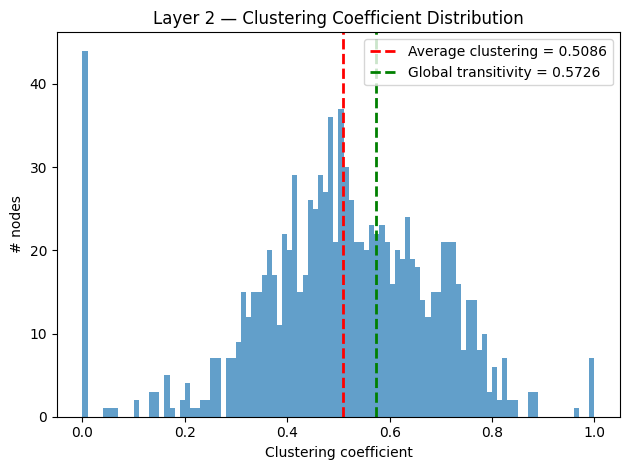

In [30]:
# === 1) Clustering globale e media ===
G = layer2

global_transitivity = nx.transitivity(G)
average_clustering  = nx.average_clustering(G)

print(f"Layer 2 — Global transitivity: {global_transitivity:.4f}")
print(f"Layer 2 — Average clustering:  {average_clustering:.4f}")

# === 2) Clustering locale per nodo ===
local_clust = nx.clustering(G)

df_layer2 = pd.DataFrame({
    "node": list(local_clust.keys()),
    "clustering": list(local_clust.values()),
    "degree": [G.degree(n) for n in local_clust.keys()]
}).sort_values(["clustering", "degree", "node"], ascending=[False, False, True]).reset_index(drop=True)

display(df_layer2.head(10))

# === 3) Istogramma ===
plt.figure()
plt.hist(df_layer2["clustering"].dropna(), bins=100, alpha=0.7)
plt.axvline(average_clustering, color='red', linestyle='--', linewidth=2,
            label=f"Average clustering = {average_clustering:.4f}")
plt.axvline(global_transitivity, color='green', linestyle='--', linewidth=2,
            label=f"Global transitivity = {global_transitivity:.4f}")
# -----------------------

plt.title("Layer 2 — Clustering Coefficient Distribution")
plt.xlabel("Clustering coefficient")
plt.ylabel("# nodes")
plt.legend()
plt.tight_layout()
plt.show()

Layer 2 — Global transitivity: 0.4863
Layer 2 — Average clustering:  0.4185


,node,clustering,degree
0,0x0e63d633af0db639f7ae85b2c0011fee96fba71a,1.000000,4
1,0xff3327cc139449fa111ad87351bb300e9cc7607c,1.000000,3
2,0x4599acc33c2c8f47dcb9646d5120a874fcb6b1d6,1.000000,2
3,0x488e8998712a27d4510fe72e8a466ef8c50b6bbf,1.000000,2
4,0x8c365a8adb600b594ee813f2948b129c7d6b23b7,1.000000,2
5,0xe1eedbd1e08478707c794e7e8b1ee623f5fa6d64,1.000000,2
6,0xe400a85a6169bd8be439bb0dc9eac81f19f26843,1.000000,2
7,0xcec7b0e69289dc3e5ec58f5908d706d3cc448165,0.866667,25
8,0x8115589165434b62556e4c1d711fb4cddf9ac69a,0.802198,14
9,0x72b68ba6bab0a5c3862cf8fc9485abd5df54ab8c,0.778656,23


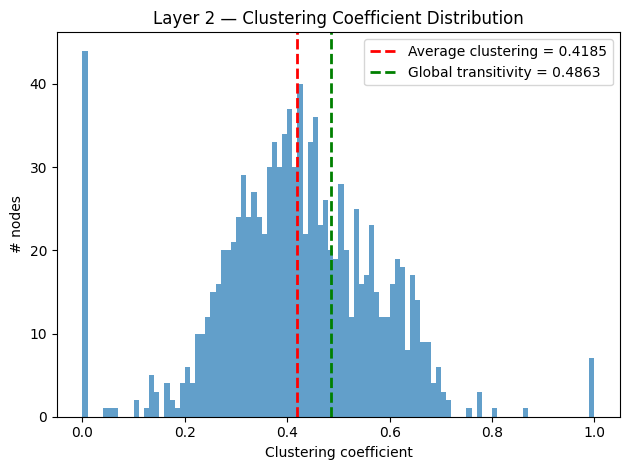

In [31]:
# === 1) Clustering globale e media ===
G = null_model

global_transitivity = nx.transitivity(G)
average_clustering  = nx.average_clustering(G)

print(f"Layer 2 — Global transitivity: {global_transitivity:.4f}")
print(f"Layer 2 — Average clustering:  {average_clustering:.4f}")

# === 2) Clustering locale per nodo ===
local_clust = nx.clustering(G)

df_layer2 = pd.DataFrame({
    "node": list(local_clust.keys()),
    "clustering": list(local_clust.values()),
    "degree": [G.degree(n) for n in local_clust.keys()]
}).sort_values(["clustering", "degree", "node"], ascending=[False, False, True]).reset_index(drop=True)

display(df_layer2.head(10))

# === 3) Istogramma ===
plt.figure()
plt.hist(df_layer2["clustering"].dropna(), bins=100, alpha=0.7)
plt.axvline(average_clustering, color='red', linestyle='--', linewidth=2,
            label=f"Average clustering = {average_clustering:.4f}")
plt.axvline(global_transitivity, color='green', linestyle='--', linewidth=2,
            label=f"Global transitivity = {global_transitivity:.4f}")
# -----------------------

plt.title("Layer 2 — Clustering Coefficient Distribution")
plt.xlabel("Clustering coefficient")
plt.ylabel("# nodes")
plt.legend()
plt.tight_layout()
plt.show()